In [ ]:
from google.colab import files
files.upload()


Saving Reviews.xlsx to Reviews.xlsx


{'Reviews.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00b\xee\x9dh^\x01\x00\x00\x90\x04\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot') #using a built-in type

In [ ]:
df = pd.read_excel("Reviews.xlsx")
df.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


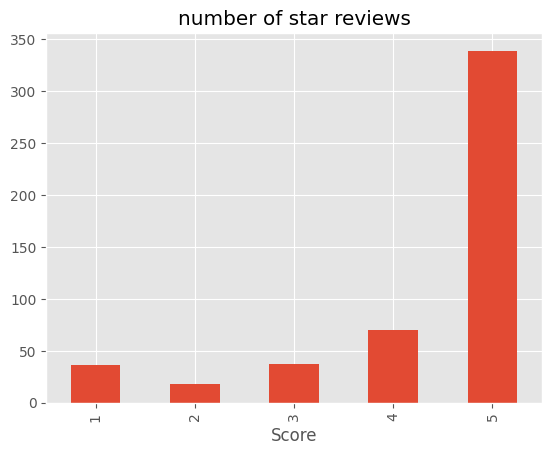

In [ ]:
df['Score'].value_counts().sort_index().plot(kind='bar', title='number of star reviews')
plt.show()

Some of the ntlk lib functions !

In [ ]:
example = df['Text'][100]
print(example)
nltk.download('punkt')
nltk.download('punkt_tab')
tokens = nltk.word_tokenize(example)
tokens[:10]


nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)

nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged) #chunking the tokens into grps of the type (determiner + adj (if any) + noun)
entities.pprint()

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  The/DT
  mouth/NN
  says/VBZ
  ,/,
  ``/``
  How/WRB
  do/VB
  I/PRP
  love/VB
  thee/NN
  ,/,
  let/VB
  me/PRP
  count/VB
  the/DT
  ways/NNS
  .../:
  ''/''
  </VBZ
  br/NN
  //NNP
  >/NNP
  If/IN
  you/PRP
  like/VBP
  apple/NN
  products/NNS
  a/DT
  must/MD
  have/VB
  item/NN
  ./.
  The/DT
  only/JJ
  draw/NN
  back/RB
  ,/,
  shipping/VBG
  cost/NN
  ./.
  These/DT
  are/VBP
  very/RB
  heavy/JJ
  ./.)


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer #VADER sentiment analyzer
from tqdm.notebook import tqdm #progress bar


nltk.download('vader_lexicon')
senti = SentimentIntensityAnalyzer()
print(senti.polarity_scores('i really like this hello kitty plushie!'))
print(example)
print(senti.polarity_scores(example))

result = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['Id']
  result[myid]= senti.polarity_scores(text)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.474}
The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.
{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
#to join df and senti data together
vaders = pd.DataFrame(result).T #T transposes the dict
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how='inner')


<ipython-input-11-e08b4e64539a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  graph =sns.barplot(data=vaders,x='Score',y='compound',palette='pastel')


(-0.5, 1.0)

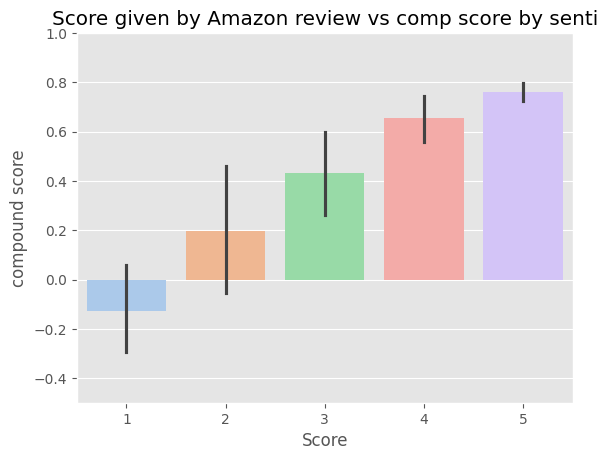

In [ ]:
#visualizing results !! (assuming a higher score means the product is evoking positive emotions and vice versa)
graph =sns.barplot(data=vaders,x='Score',y='compound',palette='pastel')
graph.set_title("Score given by Amazon review vs comp score by senti")
graph.set_ylabel("compound score")
graph.set_ylim(-0.5, 1)

The Roberta Pretrained Model !

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification #used for text sentiment analysis
from scipy.special import softmax #Taking a vector and converting it into a prob dist

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" #model is fine tuned on twitter data !
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = senti.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Broke for id 83
Broke for id 187


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Comparing Results of the VADER model with the ROBERTA model

In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

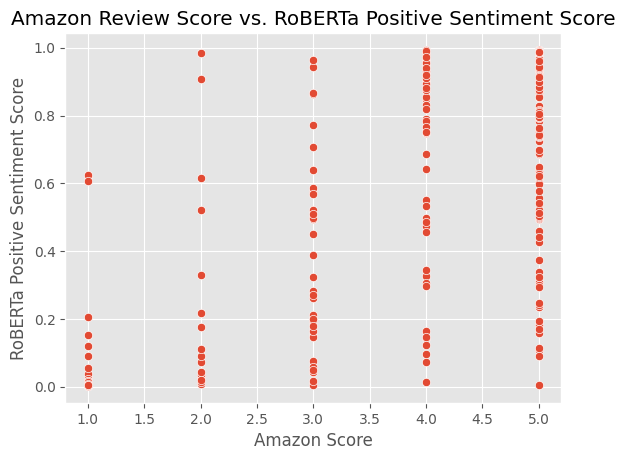

In [ ]:
sns.scatterplot(data=results_df, x='Score', y='roberta_pos')
plt.title('Amazon Review Score vs. RoBERTa Positive Sentiment Score')
plt.xlabel('Amazon Score')
plt.ylabel('RoBERTa Positive Sentiment Score')
plt.show()

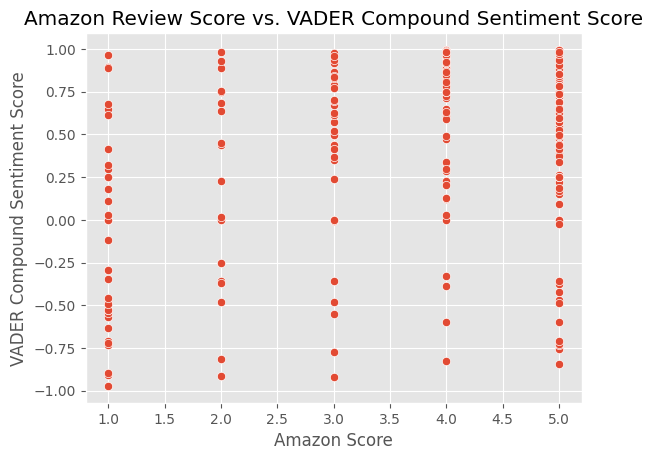

In [ ]:
sns.scatterplot(data=results_df, x='Score', y='vader_compound')
plt.title('Amazon Review Score vs. VADER Compound Sentiment Score')
plt.xlabel('Amazon Score')
plt.ylabel('VADER Compound Sentiment Score')
plt.show()

Much less outliers in the Roberta Model!